In [3]:
%reload_ext autoreload
%autoreload 2

In [10]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

import wandb

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [27]:
hs = torch.randn(2, 3, 4, 64) # b l t h

torch.norm(hs, dim=-1)

tensor([[[7.3075, 8.3307, 7.5948, 8.2794],
         [8.2917, 8.5048, 7.9685, 7.6835],
         [6.7701, 8.7494, 6.8323, 7.6135]],

        [[7.3060, 8.6134, 8.4490, 7.0520],
         [6.6969, 6.7753, 8.8448, 8.1489],
         [7.5666, 8.3536, 7.2877, 8.8651]]])

In [35]:
torch.pow(np.abs(hs), 2).mean(-1).sqrt()

tensor([[[0.9134, 1.0413, 0.9494, 1.0349],
         [1.0365, 1.0631, 0.9961, 0.9604],
         [0.8463, 1.0937, 0.8540, 0.9517]],

        [[0.9133, 1.0767, 1.0561, 0.8815],
         [0.8371, 0.8469, 1.1056, 1.0186],
         [0.9458, 1.0442, 0.9110, 1.1081]]])

In [36]:
np.sqrt(0)

0.0

In [34]:
torch.pow(np.abs(hs), 2).sum(-1).sqrt()

tensor([[[7.3075, 8.3307, 7.5948, 8.2794],
         [8.2917, 8.5048, 7.9685, 7.6835],
         [6.7701, 8.7494, 6.8323, 7.6135]],

        [[7.3060, 8.6134, 8.4490, 7.0520],
         [6.6969, 6.7753, 8.8448, 8.1489],
         [7.5666, 8.3536, 7.2877, 8.8651]]])

In [30]:
torch.pow(np.abs(hs), 2).mean(-1)

tensor([[[0.8344, 1.0844, 0.9013, 1.0711],
         [1.0743, 1.1302, 0.9921, 0.9224],
         [0.7162, 1.1961, 0.7294, 0.9057]],

        [[0.8340, 1.1592, 1.1154, 0.7770],
         [0.7008, 0.7173, 1.2223, 1.0376],
         [0.8946, 1.0903, 0.8298, 1.2280]]])

In [28]:
torch.norm_except_dim(hs, dim=0).shape

torch.Size([2, 1, 1, 1])

In [16]:
torch.pow(np.abs(hs), 2).mean(1)

tensor([0.8035, 0.9562])

## Hinge on nll

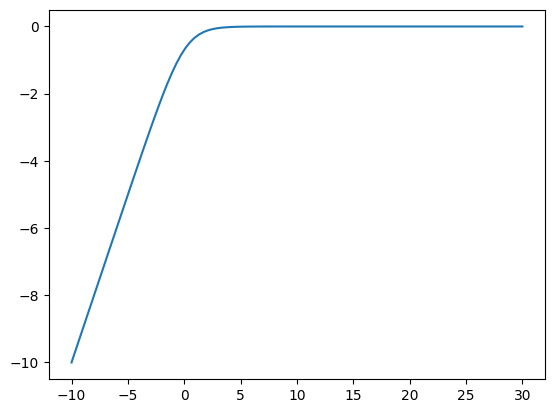

In [26]:
from torch.nn import functional as F
import torch
ref_nll_loss = torch.tensor(11)

nll_loss = torch.tensor(20)

x = torch.linspace(-10, 30, 100) # nll_loss - ref_nll_loss
y = F.softplus(x+ -1 * torch.log(torch.tensor(0.9)))
y = F.logsigmoid(x)

from matplotlib import pyplot as plt
plt.plot(x, y)

In [44]:
import numpy as np
np.exp(5)
np.log(1.1)

0.09531017980432493

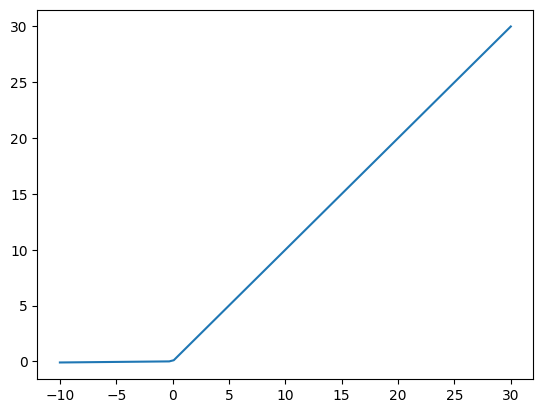

In [48]:
y = F.leaky_relu(x + 0.)
plt.plot(x, y)

## projecting dirs

In [21]:

pi_hs_cho = torch.tensor([0.1, 0.2]) # policy hidden states chosen
pi_hs_rej = torch.tensor([0.4, 0.3]) # same but rejected
dir = pi_hs_cho - pi_hs_rej
ref_hs_cho = torch.tensor([0.1, 0.1]) # reference_model hidden states chosen
ref_hs_rej = torch.tensor([0.5, 0.4])
ref_dir = ref_hs_cho - ref_hs_rej

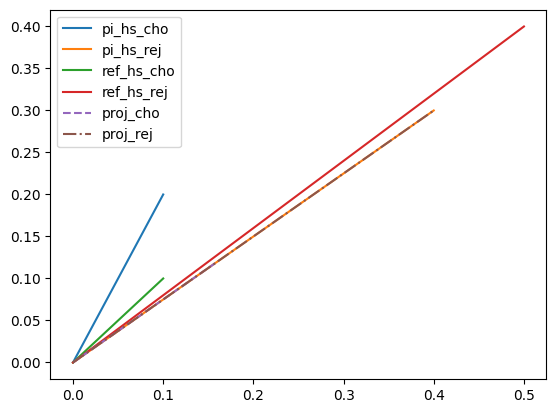

In [107]:

# Project both onto ref_dir
proj_cho = torch.dot(pi_hs_cho, ref_dir) / torch.dot(ref_dir, ref_dir) * ref_dir
proj_rej = torch.dot(pi_hs_rej, ref_dir) / torch.dot(ref_dir, ref_dir) * ref_dir

# Measure distance from original to projected points
dist_cho = torch.norm(proj_cho - pi_hs_cho)
dist_rej = torch.norm(proj_rej - pi_hs_rej)

loss = -(dist_cho + dist_rej)  # Negative to maximize movement

plt.plot([0, pi_hs_cho[0]], [0, pi_hs_cho[1]], label='pi_hs_cho')
plt.plot([0, pi_hs_rej[0]], [0, pi_hs_rej[1]], label='pi_hs_rej')
plt.plot([0, ref_hs_cho[0]], [0, ref_hs_cho[1]], label='ref_hs_cho')
plt.plot([0, ref_hs_rej[0]], [0, ref_hs_rej[1]], label='ref_hs_rej')
plt.plot([0, proj_cho[0]], [0, proj_cho[1]], label='proj_cho', ls='--')
plt.plot([0, proj_rej[0]], [0, proj_rej[1]], label='proj_rej', ls='-.')
plt.legend()

In [125]:
proj_cho

tensor([0.1600, 0.1200])

distances
proj_cho tensor(-0.0600)
proj_rej tensor(0.1400)
dist_cho=-0.10, dist_rej=0.14
proj_cho=-0.06, ortho_cho=0.08
proj_rej=0.14, ortho_rej=-0.02


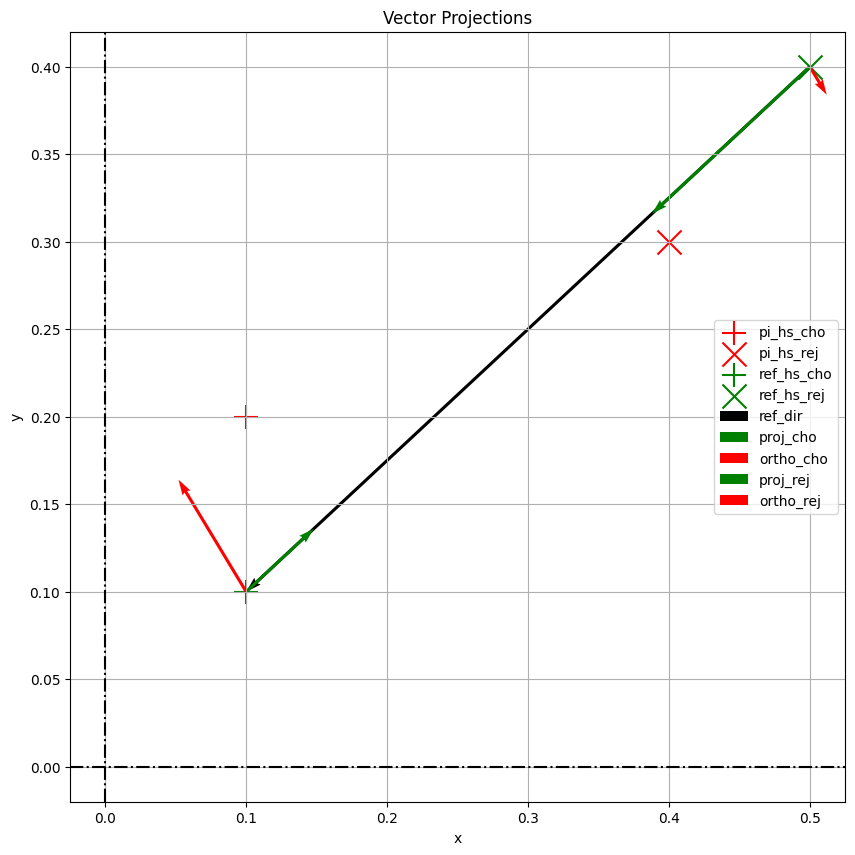

In [230]:
import matplotlib.pyplot as plt

def plot_vectors(pi_hs_cho, pi_hs_rej, ref_dir):
    plt.figure(figsize=(10, 10))
    
    # Plot original vectors
    qs = 0.5
    s= 300
    plt.scatter(*pi_hs_cho, label='pi_hs_cho', marker='+', c='red', s=s)
    plt.scatter(*pi_hs_rej, label='pi_hs_rej', marker='x', c='red', s=s)
    q_kwargs=dict(
        # headwidth=3*qs, headlength=5*qs, headaxislength=4.5*qs,
                  angles='xy', scale_units='xy', 
                  width=0.004,
                scale=1,
                  )
    plt.scatter(*ref_hs_cho, label='ref_hs_cho', marker='+', c='green', s=s)
    plt.scatter(*ref_hs_rej, label='ref_hs_rej', marker='x', c='green', s=s)
    plt.quiver(*ref_hs_rej, ref_dir[0], ref_dir[1], color='k', label='ref_dir', **q_kwargs)
    # plt.quiver(0, 0, pi_hs_cho[0], pi_hs_cho[1], angles='xy', scale_units='xy', scale=1, color='r', label='pi_hs_cho')
    # plt.quiver(0, 0, pi_hs_rej[0], pi_hs_rej[1], angles='xy', scale_units='xy', scale=1, color='b', label='pi_hs_rej')
    
    # Plot projections
    dot = torch.linalg.vecdot

    def proj(a, b):
        """Project a onto b"""
        return dot(a, b) / dot(b, b) * b
    def dist(a):
        """Distance from origin"""
        return torch.norm(a) * torch.sign(dot(a, ref_dir))
    
    cho = pi_hs_cho-ref_hs_cho
    proj_cho = proj(cho, ref_dir)
    ortho_cho = cho - proj_cho
    rej = pi_hs_rej-ref_hs_rej
    proj_rej = proj(rej, ref_dir)
    ortho_rej = rej - proj_rej

    print('distances')
    print('proj_cho', torch.dot(cho, ref_dir) / torch.dot(ref_dir, ref_dir) * torch.norm(ref_dir)) 
    print('proj_rej', torch.dot(rej, ref_dir) / torch.dot(ref_dir, ref_dir) * torch.norm(ref_dir) )
    
    print(f"dist_cho={dist(cho):2.2f}, dist_rej={dist(rej):2.2f}")
    print(f"proj_cho={dist(proj_cho):2.2f}, ortho_cho={dist(ortho_cho):2.2f}")
    print(f"proj_rej={dist(proj_rej):2.2f}, ortho_rej={dist(ortho_rej):2.2f}")

    
    plt.quiver(*ref_hs_cho, *proj_cho,
                color='green', 
                label='proj_cho', 
                # alpha=0.5,
                **q_kwargs
                )
    plt.quiver(*ref_hs_cho, *ortho_cho, 
                color='red', 
                label='ortho_cho', 
                **q_kwargs
                )
  
    plt.quiver(*ref_hs_rej, *proj_rej,
              #  proj_rej[0], proj_rej[1], 
                  label='proj_rej', color='g', **q_kwargs)
    plt.quiver(*ref_hs_rej, *ortho_rej, 
                color='red', 
                label='ortho_rej', 
                **q_kwargs
                )
    
    plt.axhline(y=0, color='k', linestyle='-.')
    plt.axvline(x=0, color='k', linestyle='-.')
    plt.legend()
    plt.grid(True)
    # plt.axis('equal')
    plt.title('Vector Projections')
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.show()

plot_vectors(pi_hs_cho, pi_hs_rej, ref_dir)

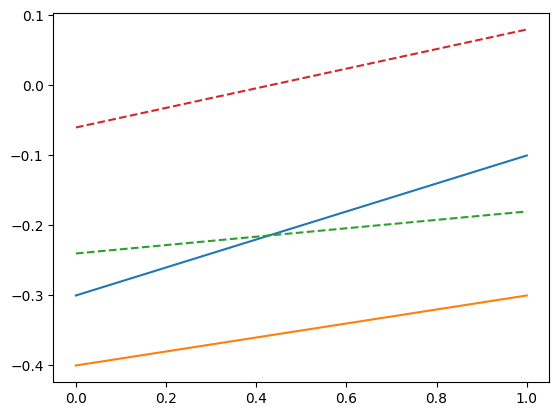

In [31]:
plt.plot(dir)
plt.plot(ref_dir)

ref_dir_norm = ref_dir / torch.norm(ref_dir, dim=-1, keepdim=True)
proj = torch.sum(dir * ref_dir_norm, dim=-1, keepdim=True) * ref_dir_norm
plt.plot(proj, ls='--')
orth = dir - proj
plt.plot(orth, ls='--')

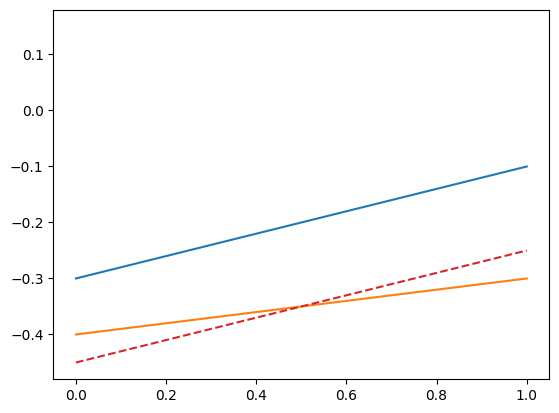

In [36]:
plt.plot(dir)
plt.plot(ref_dir)


proj = torch.dot(dir, ref_dir)
plt.plot(proj, ls='--')
orth = dir - proj
plt.plot(orth, ls='--')

In [70]:
dir * ref_dir

tensor([0.1200, 0.0300])

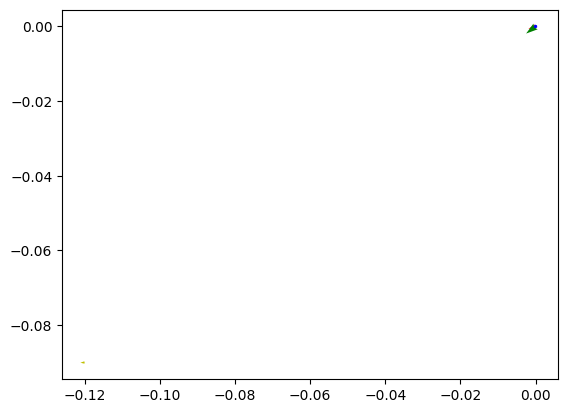

In [86]:
ref_dir_norm = ref_dir / (torch.norm(ref_dir, dim=-1, keepdim=True) + 1e-8)
    
# Projection (dot product)
proj = torch.sum(dir * ref_dir_norm, dim=-1, keepdim=True) * ref_dir
# proj = -dir * ref_dir # torch.dot(dir, ref_dir) * ref_dir_norm
# Orthogonal component (cross product)
# cross = torch.cross(dir, ref_dir_norm, dim=-1)
# orth = torch.cross(ref_dir_norm, cross, dim=-1)
orth = dir - proj
s=20
plt.quiver(0, 0, *dir*s, color=['r',], scale=21)
plt.quiver(0, 0, *ref_dir*s, color=['g',], scale=21)
plt.quiver(0, 0, *proj*s, color=['b',], scale=21)
plt.quiver(*proj*s, *orth*s, color=['y',], scale=21)
plt.show()

# plt.plot(dir)
# plt.plot(ref_dir)
# plt.plot(proj)
